# SNS Take Home Assessment

### Libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import nltk
import os
import time
import shutil
from matplotlib import pyplot as plt
from torchvision import datasets, transforms, models
import torch.nn as nn
from torch.utils.data import DataLoader
import argparse
import torch.optim as optim
from torchvision.datasets import ImageFolder
import seaborn as sns
from sklearn.metrics import confusion_matrix
import csv
from scipy.io import loadmat

### Importing dataset

In [10]:
class_names = pd.read_csv("./Stanford Cars Dataset/annotations/class_names.csv", header = None, names = ['Models'])
car_annot = pd.read_csv("./Stanford Cars Dataset/annotations/cars_annos.csv", header = None, names = ['Raw'])

In [11]:
class_names.head()

,Models
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


In [12]:
car_annot.head()

,Raw
0,Image;x1;y1;x2;y2;class;test
1,000001.jpg;112;7;853;717;1;0
2,000002.jpg;48;24;441;202;1;0
3,000003.jpg;7;4;277;180;1;0
4,000004.jpg;33;50;197;150;1;0


### Pre-Processing

In [13]:
# Make a new df to not modify original
car_annot2 = car_annot.copy()

In [14]:
def split_text(text):
    split = text.split(";")
    return split

In [15]:
# Split string into seperate columns in the dataframe
car_annot2[["Image","x1", "y1","x2","y2","Class","Test"]] = car_annot2['Raw'].str.split(";", expand = True)

In [16]:
# Remove first row and first column
car_annot2 = car_annot2.iloc[1: ,1:]

In [17]:
car_annot2

,Image,x1,y1,x2,y2,Class,Test
1,000001.jpg,112,7,853,717,1,0
2,000002.jpg,48,24,441,202,1,0
3,000003.jpg,7,4,277,180,1,0
4,000004.jpg,33,50,197,150,1,0
5,000005.jpg,5,8,83,58,1,0
...,...,...,...,...,...,...,...
16181,016181.jpg,38,36,375,234,196,1
16182,016182.jpg,29,34,235,164,196,1
16183,016183.jpg,25,32,587,359,196,1
16184,016184.jpg,56,60,208,186,196,1


In [18]:
car_annot2["Class"] = pd.to_numeric(car_annot2.Class)

In [19]:
class_names

,Models
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012
...,...
191,Volkswagen Beetle Hatchback 2012
192,Volvo C30 Hatchback 2012
193,Volvo 240 Sedan 1993
194,Volvo XC90 SUV 2007


In [20]:
# Map class index to their corresponding car models
models_dict = class_names.to_dict("dict")

In [21]:
models_dict

{'Models': {0: 'AM General Hummer SUV 2000',
  1: 'Acura RL Sedan 2012',
  2: 'Acura TL Sedan 2012',
  3: 'Acura TL Type-S 2008',
  4: 'Acura TSX Sedan 2012',
  5: 'Acura Integra Type R 2001',
  6: 'Acura ZDX Hatchback 2012',
  7: 'Aston Martin V8 Vantage Convertible 2012',
  8: 'Aston Martin V8 Vantage Coupe 2012',
  9: 'Aston Martin Virage Convertible 2012',
  10: 'Aston Martin Virage Coupe 2012',
  11: 'Audi RS 4 Convertible 2008',
  12: 'Audi A5 Coupe 2012',
  13: 'Audi TTS Coupe 2012',
  14: 'Audi R8 Coupe 2012',
  15: 'Audi V8 Sedan 1994',
  16: 'Audi 100 Sedan 1994',
  17: 'Audi 100 Wagon 1994',
  18: 'Audi TT Hatchback 2011',
  19: 'Audi S6 Sedan 2011',
  20: 'Audi S5 Convertible 2012',
  21: 'Audi S5 Coupe 2012',
  22: 'Audi S4 Sedan 2012',
  23: 'Audi S4 Sedan 2007',
  24: 'Audi TT RS Coupe 2012',
  25: 'BMW ActiveHybrid 5 Sedan 2012',
  26: 'BMW 1 Series Convertible 2012',
  27: 'BMW 1 Series Coupe 2012',
  28: 'BMW 3 Series Sedan 2012',
  29: 'BMW 3 Series Wagon 2012',
  30

In [22]:
car_annot2["Class"] = car_annot2["Class"]-1

In [23]:
car_annot2

,Image,x1,y1,x2,y2,Class,Test
1,000001.jpg,112,7,853,717,0,0
2,000002.jpg,48,24,441,202,0,0
3,000003.jpg,7,4,277,180,0,0
4,000004.jpg,33,50,197,150,0,0
5,000005.jpg,5,8,83,58,0,0
...,...,...,...,...,...,...,...
16181,016181.jpg,38,36,375,234,195,1
16182,016182.jpg,29,34,235,164,195,1
16183,016183.jpg,25,32,587,359,195,1
16184,016184.jpg,56,60,208,186,195,1


In [24]:
# Make a copy of df2 to not alter df2 further
car_annot3 = car_annot2.copy()

### Mapping Class number to Model

In [25]:
# Add a "Models" column to df3 according to their class index
car_annot3["Models"] = car_annot3["Class"].map(models_dict['Models'])

In [26]:
car_annot3

,Image,x1,y1,x2,y2,Class,Test,Models
1,000001.jpg,112,7,853,717,0,0,AM General Hummer SUV 2000
2,000002.jpg,48,24,441,202,0,0,AM General Hummer SUV 2000
3,000003.jpg,7,4,277,180,0,0,AM General Hummer SUV 2000
4,000004.jpg,33,50,197,150,0,0,AM General Hummer SUV 2000
5,000005.jpg,5,8,83,58,0,0,AM General Hummer SUV 2000
...,...,...,...,...,...,...,...,...
16181,016181.jpg,38,36,375,234,195,1,smart fortwo Convertible 2012
16182,016182.jpg,29,34,235,164,195,1,smart fortwo Convertible 2012
16183,016183.jpg,25,32,587,359,195,1,smart fortwo Convertible 2012
16184,016184.jpg,56,60,208,186,195,1,smart fortwo Convertible 2012


### Split into 2 dataframes - Train and Test

In [27]:
pd.options.mode.chained_assignment = None       # Removes warning message

In [28]:
train_annot = car_annot3.loc[(car_annot3["Test"] == "0")]
test_annot = car_annot3.loc[(car_annot3["Test"] == "1")]

### Make bounding boxes

In [29]:
train_annot['y2'] = train_annot['y2'].astype(int)
train_annot['y1'] = train_annot['y1'].astype(int)
train_annot['x2'] = train_annot['x2'].astype(int)
train_annot['x1'] = train_annot['x1'].astype(int)

In [30]:
# Define bounding box height and width
train_annot['bbox_h'] = ((train_annot['y2'] - train_annot['y1']) + 1)
train_annot['bbox_w'] = ((train_annot['x2'] - train_annot['x1']) + 1)

In [31]:
train_annot

,Image,x1,y1,x2,y2,Class,Test,Models,bbox_h,bbox_w
1,000001.jpg,112,7,853,717,0,0,AM General Hummer SUV 2000,711,742
2,000002.jpg,48,24,441,202,0,0,AM General Hummer SUV 2000,179,394
3,000003.jpg,7,4,277,180,0,0,AM General Hummer SUV 2000,177,271
4,000004.jpg,33,50,197,150,0,0,AM General Hummer SUV 2000,101,165
5,000005.jpg,5,8,83,58,0,0,AM General Hummer SUV 2000,51,79
...,...,...,...,...,...,...,...,...,...,...
16141,016141.jpg,42,9,573,366,195,0,smart fortwo Convertible 2012,358,532
16142,016142.jpg,183,4,1186,780,195,0,smart fortwo Convertible 2012,777,1004
16143,016143.jpg,121,87,465,278,195,0,smart fortwo Convertible 2012,192,345
16144,016144.jpg,21,30,468,320,195,0,smart fortwo Convertible 2012,291,448


In [32]:
train_annot.to_csv("./Stanford Cars Dataset/annotations/train_annots.csv")

In [33]:
test_annot

,Image,x1,y1,x2,y2,Class,Test,Models
46,000046.jpg,14,16,268,169,0,1,AM General Hummer SUV 2000
47,000047.jpg,10,18,89,61,0,1,AM General Hummer SUV 2000
48,000048.jpg,111,54,365,190,0,1,AM General Hummer SUV 2000
49,000049.jpg,9,33,479,276,0,1,AM General Hummer SUV 2000
50,000050.jpg,9,3,93,41,0,1,AM General Hummer SUV 2000
...,...,...,...,...,...,...,...,...
16181,016181.jpg,38,36,375,234,195,1,smart fortwo Convertible 2012
16182,016182.jpg,29,34,235,164,195,1,smart fortwo Convertible 2012
16183,016183.jpg,25,32,587,359,195,1,smart fortwo Convertible 2012
16184,016184.jpg,56,60,208,186,195,1,smart fortwo Convertible 2012


In [34]:
test_annot['y2'] = test_annot['y2'].astype(int)
test_annot['y1'] = test_annot['y1'].astype(int)
test_annot['x2'] = test_annot['x2'].astype(int)
test_annot['x1'] = test_annot['x1'].astype(int)

In [35]:
# Define bounding box height and width
test_annot['bbox_h'] = ((test_annot['y2'] - test_annot['y1']) + 1)
test_annot['bbox_w'] = ((test_annot['x2'] - test_annot['x1']) + 1)

In [41]:
test_annot

,Image,x1,y1,x2,y2,Class,Test,Models,bbox_h,bbox_w
46,000046.jpg,14,16,268,169,0,1,AM General Hummer SUV 2000,154,255
47,000047.jpg,10,18,89,61,0,1,AM General Hummer SUV 2000,44,80
48,000048.jpg,111,54,365,190,0,1,AM General Hummer SUV 2000,137,255
49,000049.jpg,9,33,479,276,0,1,AM General Hummer SUV 2000,244,471
50,000050.jpg,9,3,93,41,0,1,AM General Hummer SUV 2000,39,85
...,...,...,...,...,...,...,...,...,...,...
16181,016181.jpg,38,36,375,234,195,1,smart fortwo Convertible 2012,199,338
16182,016182.jpg,29,34,235,164,195,1,smart fortwo Convertible 2012,131,207
16183,016183.jpg,25,32,587,359,195,1,smart fortwo Convertible 2012,328,563
16184,016184.jpg,56,60,208,186,195,1,smart fortwo Convertible 2012,127,153


In [42]:
test_annot.to_csv("./Stanford Cars Dataset/annotations/test_annots.csv")

### Move images into train and test folders respectively

In [43]:
movdir = "./Stanford Cars Dataset/car_im_train/"
basedir = "./Stanford Cars Dataset/car_ims/"


count = 0
for i in train_annot["Image"]:
    shutil.copy(basedir+i, movdir+i)
    count += 1
    print("Copied:", count)

Copied: 1
Copied: 2
Copied: 3
Copied: 4
Copied: 5
Copied: 6
Copied: 7
Copied: 8
Copied: 9
Copied: 10
Copied: 11
Copied: 12
Copied: 13
Copied: 14
Copied: 15
Copied: 16
Copied: 17
Copied: 18
Copied: 19
Copied: 20
Copied: 21
Copied: 22
Copied: 23
Copied: 24
Copied: 25
Copied: 26
Copied: 27
Copied: 28
Copied: 29
Copied: 30
Copied: 31
Copied: 32
Copied: 33
Copied: 34
Copied: 35
Copied: 36
Copied: 37
Copied: 38
Copied: 39
Copied: 40
Copied: 41
Copied: 42
Copied: 43
Copied: 44
Copied: 45
Copied: 46
Copied: 47
Copied: 48
Copied: 49
Copied: 50
Copied: 51
Copied: 52
Copied: 53
Copied: 54
Copied: 55
Copied: 56
Copied: 57
Copied: 58
Copied: 59
Copied: 60
Copied: 61
Copied: 62
Copied: 63
Copied: 64
Copied: 65
Copied: 66
Copied: 67
Copied: 68
Copied: 69
Copied: 70
Copied: 71
Copied: 72
Copied: 73
Copied: 74
Copied: 75
Copied: 76
Copied: 77
Copied: 78
Copied: 79
Copied: 80
Copied: 81
Copied: 82
Copied: 83
Copied: 84
Copied: 85
Copied: 86
Copied: 87
Copied: 88
Copied: 89
Copied: 90
Copied: 91
Copied: 

In [44]:
movdir = "./Stanford Cars Dataset/car_im_test/"
basedir = "./Stanford Cars Dataset/car_ims/"

count = 0
for i in test_annot["Image"]:
    shutil.copy(basedir+i, movdir+i)
    count += 1
    print("Copied:", count)

Copied: 1
Copied: 2
Copied: 3
Copied: 4
Copied: 5
Copied: 6
Copied: 7
Copied: 8
Copied: 9
Copied: 10
Copied: 11
Copied: 12
Copied: 13
Copied: 14
Copied: 15
Copied: 16
Copied: 17
Copied: 18
Copied: 19
Copied: 20
Copied: 21
Copied: 22
Copied: 23
Copied: 24
Copied: 25
Copied: 26
Copied: 27
Copied: 28
Copied: 29
Copied: 30
Copied: 31
Copied: 32
Copied: 33
Copied: 34
Copied: 35
Copied: 36
Copied: 37
Copied: 38
Copied: 39
Copied: 40
Copied: 41
Copied: 42
Copied: 43
Copied: 44
Copied: 45
Copied: 46
Copied: 47
Copied: 48
Copied: 49
Copied: 50
Copied: 51
Copied: 52
Copied: 53
Copied: 54
Copied: 55
Copied: 56
Copied: 57
Copied: 58
Copied: 59
Copied: 60
Copied: 61
Copied: 62
Copied: 63
Copied: 64
Copied: 65
Copied: 66
Copied: 67
Copied: 68
Copied: 69
Copied: 70
Copied: 71
Copied: 72
Copied: 73
Copied: 74
Copied: 75
Copied: 76
Copied: 77
Copied: 78
Copied: 79
Copied: 80
Copied: 81
Copied: 82
Copied: 83
Copied: 84
Copied: 85
Copied: 86
Copied: 87
Copied: 88
Copied: 89
Copied: 90
Copied: 91
Copied: 

### Create subfolders for each car model

In [50]:
newpath_train = "./Stanford Cars Dataset/cars_train_classes/"

for i in pd.unique(train_annot["Models"]):
    newpath_train2 = newpath_train + i
    if not os.path.exists(newpath_train2):
        os.makedirs(newpath_train2)
        print("Created folder:", newpath_train2)
    else:
        print("Folder exists")

Created folder: ./Stanford Cars Dataset/cars_train_classes/AM General Hummer SUV 2000
Created folder: ./Stanford Cars Dataset/cars_train_classes/Acura RL Sedan 2012
Created folder: ./Stanford Cars Dataset/cars_train_classes/Acura TL Sedan 2012
Created folder: ./Stanford Cars Dataset/cars_train_classes/Acura TL Type-S 2008
Created folder: ./Stanford Cars Dataset/cars_train_classes/Acura TSX Sedan 2012
Created folder: ./Stanford Cars Dataset/cars_train_classes/Acura Integra Type R 2001
Created folder: ./Stanford Cars Dataset/cars_train_classes/Acura ZDX Hatchback 2012
Created folder: ./Stanford Cars Dataset/cars_train_classes/Aston Martin V8 Vantage Convertible 2012
Created folder: ./Stanford Cars Dataset/cars_train_classes/Aston Martin V8 Vantage Coupe 2012
Created folder: ./Stanford Cars Dataset/cars_train_classes/Aston Martin Virage Convertible 2012
Created folder: ./Stanford Cars Dataset/cars_train_classes/Aston Martin Virage Coupe 2012
Created folder: ./Stanford Cars Dataset/cars_tr

In [49]:
newpath_val = "./Stanford Cars Dataset/cars_val_classes/"

for i in pd.unique(train_annot["Models"]):
    newpath_val2 = newpath_val + i
    if not os.path.exists(newpath_val2):
        os.makedirs(newpath_val2)
        print("Created folder:", newpath_val2)
    else:
        print("Folder exists")

Created folder: ./Stanford Cars Dataset/cars_val_classes/AM General Hummer SUV 2000
Created folder: ./Stanford Cars Dataset/cars_val_classes/Acura RL Sedan 2012
Created folder: ./Stanford Cars Dataset/cars_val_classes/Acura TL Sedan 2012
Created folder: ./Stanford Cars Dataset/cars_val_classes/Acura TL Type-S 2008
Created folder: ./Stanford Cars Dataset/cars_val_classes/Acura TSX Sedan 2012
Created folder: ./Stanford Cars Dataset/cars_val_classes/Acura Integra Type R 2001
Created folder: ./Stanford Cars Dataset/cars_val_classes/Acura ZDX Hatchback 2012
Created folder: ./Stanford Cars Dataset/cars_val_classes/Aston Martin V8 Vantage Convertible 2012
Created folder: ./Stanford Cars Dataset/cars_val_classes/Aston Martin V8 Vantage Coupe 2012
Created folder: ./Stanford Cars Dataset/cars_val_classes/Aston Martin Virage Convertible 2012
Created folder: ./Stanford Cars Dataset/cars_val_classes/Aston Martin Virage Coupe 2012
Created folder: ./Stanford Cars Dataset/cars_val_classes/Audi RS 4 Co

In [46]:
newpath_test = "./Stanford Cars Dataset/cars_test_classes/"

for i in pd.unique(train_annot["Models"]):
    newpath_test2 = newpath_test + i
    if not os.path.exists(newpath_test2):
        os.makedirs(newpath_test2)
        print("Created folder:", newpath_test2)
    else:
        print("Folder exists")

Created folder: ./Stanford Cars Dataset/cars_test_classes/AM General Hummer SUV 2000
Created folder: ./Stanford Cars Dataset/cars_test_classes/Acura RL Sedan 2012
Created folder: ./Stanford Cars Dataset/cars_test_classes/Acura TL Sedan 2012
Created folder: ./Stanford Cars Dataset/cars_test_classes/Acura TL Type-S 2008
Created folder: ./Stanford Cars Dataset/cars_test_classes/Acura TSX Sedan 2012
Created folder: ./Stanford Cars Dataset/cars_test_classes/Acura Integra Type R 2001
Created folder: ./Stanford Cars Dataset/cars_test_classes/Acura ZDX Hatchback 2012
Created folder: ./Stanford Cars Dataset/cars_test_classes/Aston Martin V8 Vantage Convertible 2012
Created folder: ./Stanford Cars Dataset/cars_test_classes/Aston Martin V8 Vantage Coupe 2012
Created folder: ./Stanford Cars Dataset/cars_test_classes/Aston Martin Virage Convertible 2012
Created folder: ./Stanford Cars Dataset/cars_test_classes/Aston Martin Virage Coupe 2012
Created folder: ./Stanford Cars Dataset/cars_test_classes/

### Moving images to their specific model folders

In [51]:
movdir = "./Stanford Cars Dataset/cars_train_classes/"
valdir = "./Stanford Cars Dataset/cars_val_classes/"
basedir = "./Stanford Cars Dataset/car_im_train/"

unique_models = train_annot["Models"].unique()

# Iterate over each row in the dataframe
count = 0
for index, row in train_annot.iterrows():
    
    file_name = row["Image"]
    model = row["Models"]
    # print(file_name, model)

    if count < 7000:
        # Move the file to the respective subfolder
        src_file_path = os.path.join(basedir, file_name)
        dest_file_path = os.path.join(movdir + model + "/" + file_name)

        shutil.copy(src_file_path, dest_file_path)
        print("Copying file to ", dest_file_path, " Count =", count)
        count += 1
    else:
        src_file_path = os.path.join(basedir, file_name)
        dest_file_path = os.path.join(valdir + model + "/" + file_name)

        shutil.copy(src_file_path, dest_file_path)
        print("Copying file to ", dest_file_path, " Count =", count)
        count += 1

Copying file to  ./Stanford Cars Dataset/cars_train_classes/AM General Hummer SUV 2000/000001.jpg  Count = 0
Copying file to  ./Stanford Cars Dataset/cars_train_classes/AM General Hummer SUV 2000/000002.jpg  Count = 1
Copying file to  ./Stanford Cars Dataset/cars_train_classes/AM General Hummer SUV 2000/000003.jpg  Count = 2
Copying file to  ./Stanford Cars Dataset/cars_train_classes/AM General Hummer SUV 2000/000004.jpg  Count = 3
Copying file to  ./Stanford Cars Dataset/cars_train_classes/AM General Hummer SUV 2000/000005.jpg  Count = 4
Copying file to  ./Stanford Cars Dataset/cars_train_classes/AM General Hummer SUV 2000/000006.jpg  Count = 5
Copying file to  ./Stanford Cars Dataset/cars_train_classes/AM General Hummer SUV 2000/000007.jpg  Count = 6
Copying file to  ./Stanford Cars Dataset/cars_train_classes/AM General Hummer SUV 2000/000008.jpg  Count = 7
Copying file to  ./Stanford Cars Dataset/cars_train_classes/AM General Hummer SUV 2000/000009.jpg  Count = 8
Copying file to  ./

In [52]:
movdir = "./Stanford Cars Dataset/cars_test_classes/"
basedir = "./Stanford Cars Dataset/car_im_test/"

unique_models = test_annot["Models"].unique()

# Iterate over each row in the dataframe
count = 0
for index, row in test_annot.iterrows():
    
    file_name = row["Image"]
    model = row["Models"]
    # print(file_name, model)

    # Move the file to the respective subfolder
    src_file_path = os.path.join(basedir, file_name)
    dest_file_path = os.path.join(movdir + model + "/" + file_name)

    shutil.copy(src_file_path, dest_file_path)
    print("Copying file to ", dest_file_path, " Count =", count)
    count += 1

Copying file to  ./Stanford Cars Dataset/cars_test_classes/AM General Hummer SUV 2000/000046.jpg  Count = 0
Copying file to  ./Stanford Cars Dataset/cars_test_classes/AM General Hummer SUV 2000/000047.jpg  Count = 1
Copying file to  ./Stanford Cars Dataset/cars_test_classes/AM General Hummer SUV 2000/000048.jpg  Count = 2
Copying file to  ./Stanford Cars Dataset/cars_test_classes/AM General Hummer SUV 2000/000049.jpg  Count = 3
Copying file to  ./Stanford Cars Dataset/cars_test_classes/AM General Hummer SUV 2000/000050.jpg  Count = 4
Copying file to  ./Stanford Cars Dataset/cars_test_classes/AM General Hummer SUV 2000/000051.jpg  Count = 5
Copying file to  ./Stanford Cars Dataset/cars_test_classes/AM General Hummer SUV 2000/000052.jpg  Count = 6
Copying file to  ./Stanford Cars Dataset/cars_test_classes/AM General Hummer SUV 2000/000053.jpg  Count = 7
Copying file to  ./Stanford Cars Dataset/cars_test_classes/AM General Hummer SUV 2000/000054.jpg  Count = 8
Copying file to  ./Stanford 

# Training models

## Model 1 - ResNet-34

In [58]:
def getTrainLoad(directory):
    data = datasets.ImageFolder(directory, 
                                transform = transforms.Compose([transforms.Resize((244,244)),
                                transforms.RandomRotation(30),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
    return torch.utils.data.DataLoader(data, batch_size=128, shuffle=True)

def getTestLoad(directory):
    data = datasets.ImageFolder(directory,
                                transform = transforms.Compose([transforms.Resize((244,244)),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
    return torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)
trainLoad = getTrainLoad("./Stanford Cars Dataset/cars_train_classes")
validLoad = getTestLoad("./Stanford Cars Dataset/cars_val_classes")
testLoad = getTestLoad("./Stanford Cars Dataset/cars_test_classes")

In [59]:
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 196)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
device = 'cuda'
model.to(device)

c:\Users\hai_f\anaconda3\envs\test\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hai_f\anaconda3\envs\test\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [60]:
start = time.time()
epochs = 10
iterations = 0
val = 35
model.to(device)
model.train()

def validation(model, validloader, criterion):
    valid_loss = 0
    accuracy = 0
    model.to(device)
    for i, (images, labels) in enumerate(validloader):
        images, labels = images.to(device), labels.to(device)
        output = model.forward(images)
        valid_loss = valid_loss + criterion(output, labels).item()
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy = accuracy + equality.type(torch.FloatTensor).mean()
    return valid_loss, accuracy

v_loss_hist = list()
tr_loss_hist = list()
v_acc_hist = list()

for e in range(epochs):
    running_loss = 0
    for i, (inputs, labels) in enumerate(trainLoad):
        iterations += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #validation
        if iterations % val == 0:
            model.eval()
            with torch.no_grad():
                valid_loss, accuracy = validation(model, validLoad, criterion)
            if (e + 1) > len(v_loss_hist):
                v_loss_hist.append(round(valid_loss/len(validLoad),3))
                tr_loss_hist.append(round(running_loss/val,3))
                v_acc_hist.append(round(float(accuracy/len(validLoad)),3))
            print(f"Epoch #  {e+1}, \
            Valid Loss: {round(valid_loss/len(validLoad),5)}, \
            Training Loss: {round(running_loss/val,5)}, \
            Valid Accuracy: {round(float(accuracy/len(validLoad)),5)}")
            model.train()
            lrscheduler.step(accuracy * 100)
end = time.time()
print("Training Complete.")
print("Training time in seconds:", end - start)

Epoch #  1,             Valid Loss: 4.82327,             Training Loss: 5.24827,             Valid Accuracy: 0.06262
Epoch #  2,             Valid Loss: 3.63479,             Training Loss: 0.65615,             Valid Accuracy: 0.20147
Epoch #  2,             Valid Loss: 2.63973,             Training Loss: 4.06669,             Valid Accuracy: 0.39056
Epoch #  3,             Valid Loss: 2.05699,             Training Loss: 0.78612,             Valid Accuracy: 0.50858
Epoch #  3,             Valid Loss: 1.64027,             Training Loss: 2.79781,             Valid Accuracy: 0.59755
Epoch #  4,             Valid Loss: 1.26621,             Training Loss: 0.69515,             Valid Accuracy: 0.6799
Epoch #  4,             Valid Loss: 0.88339,             Training Loss: 1.87962,             Valid Accuracy: 0.77721
Epoch #  5,             Valid Loss: 0.85447,             Training Loss: 0.58935,             Valid Accuracy: 0.76336
Epoch #  5,             Valid Loss: 0.61234,             Training

### Plots

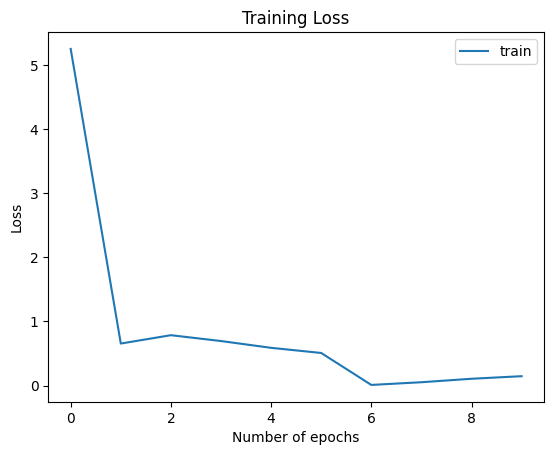

In [61]:
plt.plot(tr_loss_hist)
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper right')
plt.show()

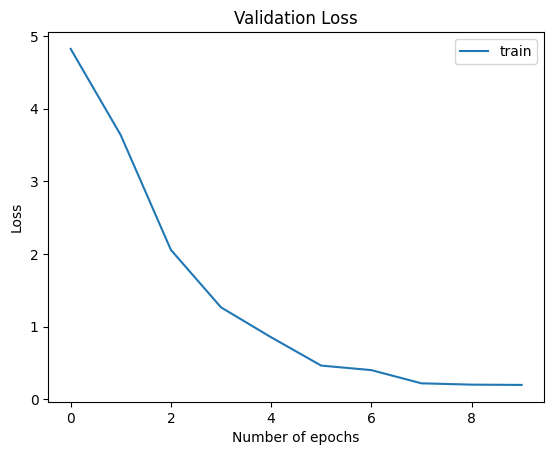

In [72]:
plt.plot(v_loss_hist)
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper right')
plt.show()

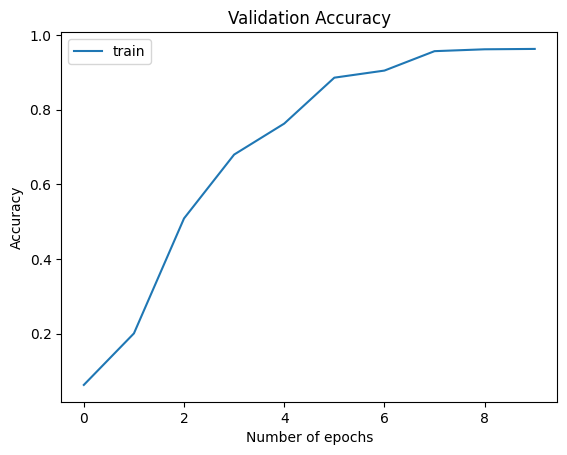

In [63]:
plt.plot(v_acc_hist)
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper left')
plt.show()

### Test Model

In [69]:
model.to(device)
"""
Tests model accuracy with test images
"""
start = time.time()
total = 0
correct = 0
acc_hist = list()
tot_hist = list()
with torch.no_grad():
    for data in testLoad:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, guess = torch.max(outputs.data, 1) 
        total = total + labels.size(0) #total num of images
        correct = correct + (guess == labels).sum().item() #number correct
        acc_hist.append(correct)
        tot_hist.append(total)
end = time.time()
print("Total images tested in model:", len(test_annot["Class"]))
print("Total accurate predictions:", correct)
print(f"Accuracy of model w/ full test dataset fed: {round(100 * correct / total,8)}%")
print("Testing time in seconds:", round(end - start))

Total images tested in model: 8041
Total accurate predictions: 6258
Accuracy of model w/ full test dataset fed: 77.82614103%
Testing time in seconds: 61


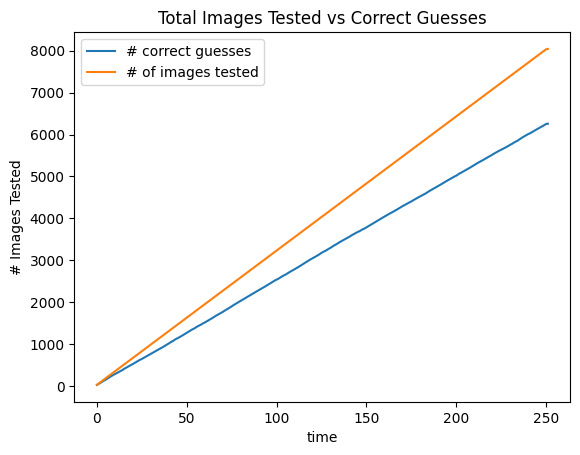

In [70]:
plt.plot(acc_hist)
plt.plot(tot_hist)
plt.title('Total Images Tested vs Correct Guesses')
plt.ylabel('# Images Tested')
plt.xlabel('time')
plt.legend(['# correct guesses', '# of images tested'], loc='upper left')
plt.show()

### Save model

In [71]:
# Save the model
torch.save(model.state_dict(), 'car_classifier_rn34.pth')
print("Model saved!")

Model saved!


## Model 2 - ResNet-50

In [2]:
def getTrainLoad(directory):
    data = datasets.ImageFolder(directory, 
                                transform = transforms.Compose([transforms.Resize((244,244)),
                                transforms.RandomRotation(30),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
    return torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)

def getTestLoad(directory):
    data = datasets.ImageFolder(directory,
                                transform = transforms.Compose([transforms.Resize((244,244)),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
    return torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)
trainLoad = getTrainLoad("./Stanford Cars Dataset/cars_train_classes")
validLoad = getTestLoad("./Stanford Cars Dataset/cars_val_classes")
testLoad = getTestLoad("./Stanford Cars Dataset/cars_test_classes")

In [3]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 196)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
device = 'cuda'
model.to(device)

c:\Users\Chun Wee\anaconda3\envs\sns\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Chun Wee\anaconda3\envs\sns\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
start = time.time()
epochs = 10
iterations = 0
val = 35
model.to(device)
model.train()

def validation(model, validloader, criterion):
    valid_loss = 0
    accuracy = 0
    model.to(device)
    for i, (images, labels) in enumerate(validloader):
        images, labels = images.to(device), labels.to(device)
        output = model.forward(images)
        valid_loss = valid_loss + criterion(output, labels).item()
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy = accuracy + equality.type(torch.FloatTensor).mean()
    return valid_loss, accuracy

v_loss_hist = list()
tr_loss_hist = list()
v_acc_hist = list()

for e in range(epochs):
    running_loss = 0
    for i, (inputs, labels) in enumerate(trainLoad):
        iterations += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #validation
        if iterations % val == 0:
            model.eval()
            with torch.no_grad():
                valid_loss, accuracy = validation(model, validLoad, criterion)
            if (e + 1) > len(v_loss_hist):
                v_loss_hist.append(round(valid_loss/len(validLoad),3))
                tr_loss_hist.append(round(running_loss/val,3))
                v_acc_hist.append(round(float(accuracy/len(validLoad)),3))
            print(f"Epoch #  {e+1}, \
            Valid Loss: {round(valid_loss/len(validLoad),5)}, \
            Training Loss: {round(running_loss/val,5)}, \
            Valid Accuracy: {round(float(accuracy/len(validLoad)),5)}")
            model.train()
            lrscheduler.step(accuracy * 100)
end = time.time()
print("Training Complete.")
print("Training time in seconds:", end - start)

Epoch #  1,             Valid Loss: 5.5514,             Training Loss: 5.44047,             Valid Accuracy: 0.01789
Epoch #  1,             Valid Loss: 4.57647,             Training Loss: 10.45871,             Valid Accuracy: 0.06691
Epoch #  1,             Valid Loss: 3.95049,             Training Loss: 14.89096,             Valid Accuracy: 0.1473
Epoch #  1,             Valid Loss: 3.56666,             Training Loss: 18.8245,             Valid Accuracy: 0.18664
Epoch #  1,             Valid Loss: 3.1945,             Training Loss: 22.45471,             Valid Accuracy: 0.2201
Epoch #  1,             Valid Loss: 3.29507,             Training Loss: 25.73428,             Valid Accuracy: 0.21422
Epoch #  1,             Valid Loss: 2.75328,             Training Loss: 28.79154,             Valid Accuracy: 0.30159
Epoch #  2,             Valid Loss: 2.34724,             Training Loss: 1.84862,             Valid Accuracy: 0.36924
Epoch #  2,             Valid Loss: 2.36981,             Traini

### Plots

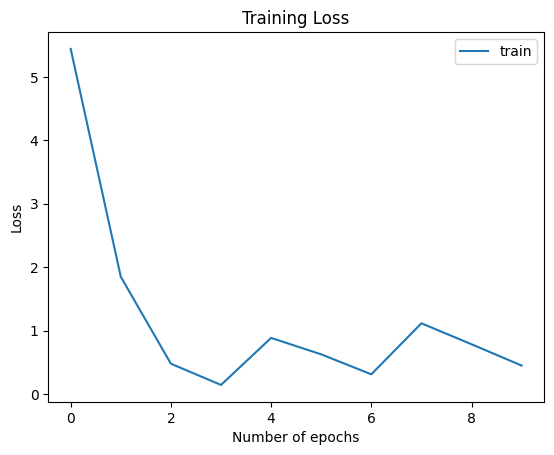

In [5]:
plt.plot(tr_loss_hist)
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper right')
plt.show()

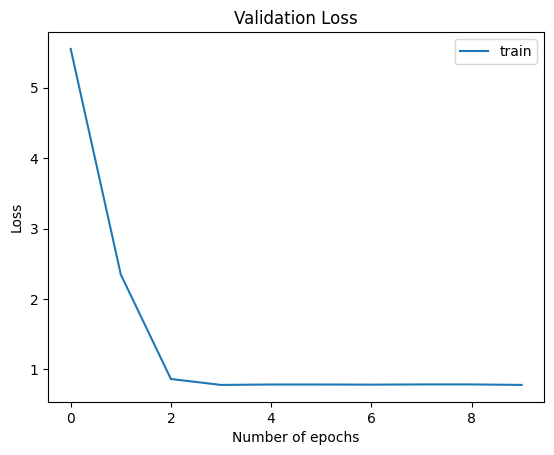

In [6]:
plt.plot(v_loss_hist)
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper right')
plt.show()

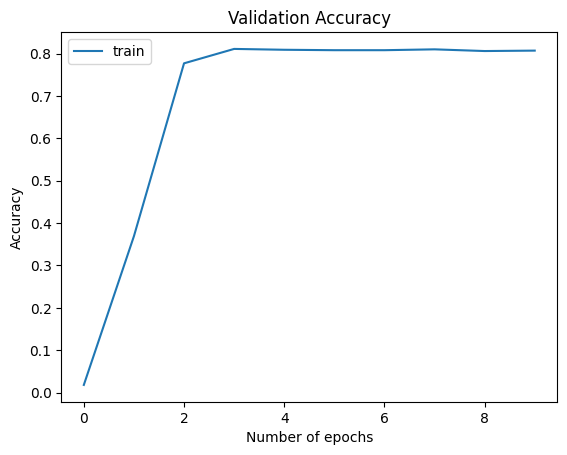

In [7]:
plt.plot(v_acc_hist)
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper left')
plt.show()

### Test Model

In [36]:
model.to(device)
"""
Tests model accuracy with test images
"""
start = time.time()
total = 0
correct = 0
acc_hist = list()
tot_hist = list()
with torch.no_grad():
    for data in testLoad:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, guess = torch.max(outputs.data, 1) 
        total = total + labels.size(0) #total num of images
        correct = correct + (guess == labels).sum().item() #number correct
        acc_hist.append(correct)
        tot_hist.append(total)
end = time.time()
print("Total images tested in model:", len(test_annot["Class"]))
print("Total accurate predictions:", correct)
print(f"Accuracy of model w/ full test dataset fed: {round(100 * correct / total,8)}%")
print("Testing time in seconds:", round(end - start))

Total images tested in model: 8041
Total accurate predictions: 5412
Accuracy of model w/ full test dataset fed: 67.30506156%
Testing time in seconds: 85


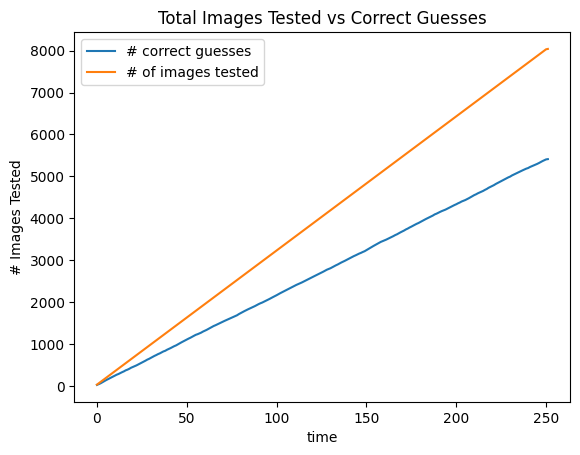

In [37]:
plt.plot(acc_hist)
plt.plot(tot_hist)
plt.title('Total Images Tested vs Correct Guesses')
plt.ylabel('# Images Tested')
plt.xlabel('time')
plt.legend(['# correct guesses', '# of images tested'], loc='upper left')
plt.show()

### Save Model

In [9]:
# Save the model
torch.save(model.state_dict(), 'car_classifier_rn50.pth')
print("Model saved!")

Model saved!


## 

Observations:

1. Transfer learning based on ResNet-50 performed worse than ResNet-34, based on training and validation losses.
2. Test accuracy of Resnet-50 based model lower than ResNet-34 model (67.3% vs 77.8%).
3. Time taken to train model based on ResNet-50 was way longer than the model based on ResNet-34.

Remarks:

1. Hyperparameter optimization is not done for this assignment as my personal laptop is struggling to train the models and might actually explode if pushed too hard.
2. Images used in training the model were full images. Looking back, the images should have been cropped first according to their bounding boxes (x1,x2,y1,y2) before training the model. Due to the lack of processing power and storage spacec on my personal laptop, I shall leave the trained model as-is, and classify this under Future Improvements. 
3. 2 models were trained in this project as I was personally curious to see the effects in using similar pretrained models. I expected ResNet50 to perform better honestly, but in this case it performs worse. May be due to its increased complexity, or maybe it can be due to the lack of optimization and tuning.
4. Training hyperparameters that can be tuned include the learning rate, optimizer used (SGD in this case), and number of epochs.